In [1]:
!pip install ultralytics

In [2]:
# ✅ Step 1: Install Ultralytics if not installed
# !pip install ultralytics --upgrade

# ✅ Step 2: Import necessary modules
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import os

# ✅ Step 3: Load the model from checkpoint directory
model = YOLO("checkpoints/yolov8n.pt")  # You can also use "runs/train/exp/weights/best.pt"

# ✅ Step 4: Run detection on your person image
image_path = "images/person.jpg"  # Replace with your actual image path
results = model(image_path)

# ✅ Step 5: Make sure output directory exists
os.makedirs("output", exist_ok=True)

# ✅ Step 6: Save the result image to the output folder
results[0].save(filename="output/output.jpg")

# ✅ Optional: Print results
print(results[0].boxes)


WARNING torchvision==0.20 is incompatible with torch==2.6.
Run 'pip install torchvision==0.21' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation

image 1/1 d:\cdsaml\docker\Virtual-Try-On\docker\images\person.jpg: 640x480 1 person, 83.8ms
Speed: 6.5ms preprocess, 83.8ms inference, 191.0ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.8887], device='cuda:0')
data: tensor([[1.9835e+02, 4.0431e+01, 6.3198e+02, 1.0221e+03, 8.8869e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1024, 768)
shape: torch.Size([1, 6])
xywh: tensor([[415.1686, 531.2514, 433.6299, 981.6407]], device='cuda:0')
xywhn: tensor([[0.5406, 0.5188, 0.5646, 0.9586]], device='cuda:0')
xyxy: tensor([[ 198.3536,   40.4311,  631.9835, 1022.0717]], device='cuda:0')
xyxyn: tensor([[0.2583, 

In [3]:
# ✅ Fix numpy + mediapipe compatibility
!pip install --force-reinstall numpy==2.0.0 mediapipe --no-cache-dir


INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
    --------------------------------------- 0.3/16.2 MB ? eta -:--:--
    --------------------------------------- 0.3/16.2 MB ? eta -:--:--
    --------------------------------------- 0.3/16.2 MB ? eta -:--:--
    --------------------------------------- 0.3/16.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.2 MB 372.4 kB/s eta 0:00:43
   - -------------------------------------- 0.5/16.2 MB 372.4 kB/s eta 0:00:43
   - -------------------------------------- 0.5/16.2 MB 372.4 kB/s eta 0:00:43
   - -------------------------------------- 0.5/16.2 MB 372.4 kB/s eta 0:00:43
   - -------------------------------------- 0.8/

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



In [4]:
# Reinstall and re-import everything due to environment reset

# STEP 1: Install dependencies again
!pip install -q opencv-python mediapipe gdown matplotlib torchvision

# STEP 2: Download u2net.py again
!wget -q https://raw.githubusercontent.com/xuebinqin/U-2-Net/master/model/u2net.py -O u2net.py


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from u2net import U2NET  # Using full model from GitHub


ModuleNotFoundError: No module named 'u2net'

In [6]:
# Create a models directory
os.makedirs("models", exist_ok=True)

# Download pretrained weights
!wget -O u2net.pth https://huggingface.co/flashingtt/U-2-Net/resolve/main/u2net.pth
!mv u2net.pth checkpoints/u2net.pth




'wget' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install transformers

In [7]:
# 🧠 STEP 2: Import Libraries
import os
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import mediapipe as mp
# from google.colab import files
from IPython.display import Image as IPImage, display
from u2net import U2NET  # Ensure u2net.py is present
from transformers import SamModel, SamProcessor

# ✅ Create output directory
os.makedirs("output", exist_ok=True)

# ✅ Load input image
image_path = 'images/person.jpg'
img = Image.open(image_path).convert("RGB")

# ⚙️ STEP 4: Load and Run U2-Net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = U2NET(3, 1)
model.load_state_dict(torch.load("checkpoints/u2net.pth", map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
])
input_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)[0]

def save_output(pred, output_path):
    pred = pred.squeeze().cpu().data.numpy()
    pred = (pred * 255).astype(np.uint8)
    im = Image.fromarray(pred)
    im.save(output_path)

save_output(output, "output/pred_mask.png")

# 🧍‍♂️ STEP 5: MediaPipe Keypoint Detection
def draw_keypoints_mediapipe(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True)
    results = pose.process(image_rgb)

    if not results.pose_landmarks:
        print("No pose landmarks detected.")
        return None, None

    annotated = image.copy()
    mp.solutions.drawing_utils.draw_landmarks(
        annotated, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
    )

    rgb_annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    skeleton_path = "output/mediapipe_keypoints.png"
    Image.fromarray(rgb_annotated).save(skeleton_path)
    return skeleton_path, results.pose_landmarks

skeleton_path, landmarks = draw_keypoints_mediapipe(image_path)

# 🎯 STEP 6: SlimSAM Point-Based Agnostic Image Generation
model_sam = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50").to(device)
processor_sam = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

# Define input points (manually or later automated from keypoints)
input_points = [[[400, 300], [600, 300], [500, 400]]]  # Format: [B, N, 2]

# Preprocess with SAM processor
inputs = processor_sam(img, input_points=input_points, return_tensors="pt").to(device)

# Predict masks
outputs = model_sam(**inputs)

# Post-process SAM output masks
processed_masks = processor_sam.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)[0]

print(f"Mask shape: {processed_masks.shape}")

# Display and save masks
for i in range(processed_masks.shape[1]):
    plt.imshow(processed_masks[0][i], cmap="gray")
    plt.title(f"Mask {i}")
    plt.axis('off')
    plt.savefig(f"output/mask_{i}.png")  # Save each mask
    plt.close()

# Select one mask (e.g., mask index 2)
mask_array = processed_masks[0][2].squeeze().numpy()
mask_img = (mask_array * 255).astype(np.uint8)
mask_1 = Image.fromarray(mask_img, mode="L")
mask_1.save("output/output_masked.jpg")
print("Mask image saved as output/output_masked.jpg")

# Generate agnostic image by applying gray over masked region
img_np = np.array(img)
gray = np.array([128, 128, 128], dtype=np.uint8)
mask_bool = mask_img > 0
agnostic_img_np = img_np.copy()
agnostic_img_np[mask_bool] = gray
agnostic_img_sam = Image.fromarray(agnostic_img_np)
agnostic_img_sam.save("output/slimsam_agnostic.png")
print("Agnostic image saved as output/slimsam_agnostic.png")

# 📤 STEP 7: Display Results
print("🎉 All steps completed. Showing outputs below:")
display(IPImage("output/pred_mask.png"))
if skeleton_path:
    display(IPImage(skeleton_path))
display(IPImage("output/slimsam_agnostic.png"))


ModuleNotFoundError: No module named 'u2net'

preprocessor_config.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

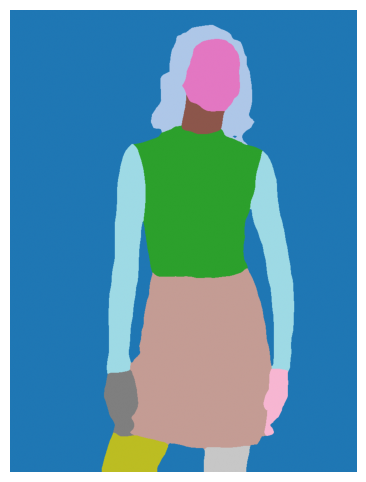

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# 📁 Ensure output folder exists
os.makedirs("output", exist_ok=True)

# 📥 Load image
image_path = "images/person.jpg"
image = Image.open(image_path).convert("RGB")

# ⚙️ Load processor and model
model_name = "yolo12138/segformer-b2-human-parse-24"
processor = SegformerImageProcessor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# 🔄 Preprocess and run inference
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# 🎯 Get predicted segmentation map
logits = outputs.logits
upsampled = torch.nn.functional.interpolate(
    logits, size=image.size[::-1], mode="bilinear", align_corners=False
)
pred = upsampled.argmax(dim=1)[0].cpu().numpy()

# 🖼️ Show only parsed output
plt.figure(figsize=(6, 6))
plt.imshow(pred, cmap="tab20")
plt.axis("off")
plt.show()

# 💾 Save mask to output folder
mask_path = "output/parsed_mask.png"
Image.fromarray(pred.astype("uint8")).save(mask_path)
print(f"✅ Segmentation mask saved to: {mask_path}")


In [ ]:
!pip install torch-tps

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from torch_tps import ThinPlateSpline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 7, 1, 3), nn.ReLU(),
            nn.Conv2d(32, 64, 5, 1, 2), nn.ReLU(),
            nn.Conv2d(64, out_channels, 3, 1, 1), nn.ReLU()
        )
    def forward(self, x):
        return self.encoder(x)

class TPSRegressor(nn.Module):
    def __init__(self, in_channels=128, num_params=18*2):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, num_params)
        )
    def forward(self, x):
        return self.regressor(x)

class GMM(nn.Module):
    def __init__(self):
        super().__init__()
        self.feat_person = FeatureExtractor()
        self.feat_cloth = FeatureExtractor()
        self.regressor = TPSRegressor()
    def forward(self, person, cloth):
        feat_p = self.feat_person(person)
        feat_c = self.feat_cloth(cloth)
        corr = torch.cat([feat_p, feat_c], 1)
        theta = self.regressor(corr)
        return theta

class TryOnGenerator(nn.Module):
    def __init__(self, in_channels=6, out_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, 1, 3), nn.ReLU(),
            nn.Conv2d(64, 128, 5, 1, 2), nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1), nn.ReLU(),
        )
        self.render = nn.Conv2d(64, out_channels, 3, 1, 1)
        self.mask = nn.Sequential(
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, agnostic, warped_cloth):
        x = torch.cat([agnostic, warped_cloth], 1)
        feat = self.encoder(x)
        render_img = self.render(feat)
        comp_mask = self.mask(feat)
        return render_img, comp_mask


In [ ]:
def warp_image_tps(source_image, theta, device):
    c_dst = theta.view(-1, 2)
    c_src = torch.stack(
        torch.meshgrid(
            torch.linspace(-1.0, 1.0, 6, device=device),
            torch.linspace(-1.0, 1.0, 3, device=device),
            indexing='xy'
        ), dim=-1
    ).view(-1, 2)

    tps = ThinPlateSpline(0.1)
    tps.fit(c_src, c_dst)

    b, c, H, W = source_image.shape
    grid = torch.stack(
        torch.meshgrid(
            torch.linspace(-1.0, 1.0, W, device=device),
            torch.linspace(-1.0, 1.0, H, device=device),
            indexing='xy'
        ), dim=-1
    )
    warped_grid = tps.transform(grid.view(-1, 2))
    warped_grid = warped_grid.view(1, H, W, 2).to(device)
    warped_image = torch.nn.functional.grid_sample(
        source_image, warped_grid, mode='bilinear',
        padding_mode='border', align_corners=False
    )
    return warped_image


In [ ]:
USE_SUPER_RES = False
SUPER_RES_MODEL = "EDSR_x4.pb"  # <-- Make sure this is available in the same folder

def upscale_image(image_pil, upscale_factor=4):
    if not USE_SUPER_RES:
        return image_pil
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    try:
        sr.readModel(SUPER_RES_MODEL)
        sr.setModel("edsr", upscale_factor)
        image_cv = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        upscaled = sr.upsample(image_cv)
        return Image.fromarray(cv2.cvtColor(upscaled, cv2.COLOR_BGR2RGB))
    except Exception as e:
        print(f"⚠️ Super-resolution failed: {e}")
        return image_pil

def run_inference(agnostic_path, cloth_path, mask_path, output_path, checkpoint_dir):
    target_size = (512, 768)
    transform = transforms.Compose([
        transforms.Resize(target_size[::-1]),
        transforms.ToTensor(),
    ])

    gmm = GMM().to(device)
    tryon_gen = TryOnGenerator().to(device)

    gmm.load_state_dict(torch.load(os.path.join(checkpoint_dir, r'gmm_pretrained.pth'), map_location=device))
    tryon_gen.load_state_dict(torch.load(os.path.join(checkpoint_dir, r'tryon_gen_pretrained.pth'), map_location=device))

    gmm.eval()
    tryon_gen.eval()

    agnostic_img = Image.open(agnostic_path).convert('RGB')
    cloth_img = Image.open(cloth_path).convert('RGB')
    mask_img = Image.open(mask_path).convert('L')

    agnostic_tensor = transform(agnostic_img).unsqueeze(0).to(device)
    cloth_tensor = transform(cloth_img).unsqueeze(0).to(device)
    mask_tensor = transform(mask_img).unsqueeze(0).to(device)

    with torch.no_grad():
        theta = gmm(agnostic_tensor, cloth_tensor)
        warped_cloth = warp_image_tps(cloth_tensor, theta, device)
        warped_mask = warp_image_tps(mask_tensor, theta, device)
        warped_cloth = warped_cloth * warped_mask

        render_img, comp_mask = tryon_gen(agnostic_tensor, warped_cloth)
        comp_mask_blend = comp_mask.expand_as(render_img)
        final_result = comp_mask_blend * warped_cloth + (1 - comp_mask_blend) * render_img

    output_tensor = final_result.squeeze(0).cpu()
    output_image = transforms.ToPILImage()(output_tensor)
    output_image = upscale_image(output_image, upscale_factor=4)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    output_image.save(output_path, quality=100)
    print(f"✅ High-resolution try-on image saved to: {output_path}")


In [ ]:
# --- DEFINE YOUR FILE PATHS HERE ---
agnostic_file      = 'images/output_agnostic.jpg'
cloth_file         = 'images/cloth1.png'
mask_file          = 'images/cloth-mask1.jpg'
checkpoint_folder  = 'checkpoints'
output_file        = 'images/highres_img.jpg'



# --- RUN THE INFERENCE ---
run_inference(
    agnostic_path=agnostic_file,
    cloth_path=cloth_file,
    mask_path=mask_file,
    output_path=output_file,
    checkpoint_dir=checkpoint_folder
)


✅ High-resolution try-on image saved to: /content/images/highres_tryon_result.png


In [8]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import os


In [9]:
import os
from PIL import Image
import torch
from diffusers import StableDiffusionInpaintPipeline
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F

# --- Advanced Alias Post-Processing Function ---
def basic_alias_postprocess(image: Image.Image, original_mask: Image.Image) -> Image.Image:
    """Alignment-aware post-processing: stronger smoothing on garment regions."""
    img_tensor = to_tensor(image).unsqueeze(0)
    mask_tensor = to_tensor(original_mask).unsqueeze(0)

    garment_regions = (mask_tensor > 0.5).float()
    background_regions = 1 - garment_regions

    smooth_garment = F.avg_pool2d(img_tensor, kernel_size=5, stride=1, padding=2)
    smooth_background = F.avg_pool2d(img_tensor, kernel_size=3, stride=1, padding=1)

    result = garment_regions * smooth_garment + background_regions * smooth_background
    return to_pil_image(result.squeeze(0))

# --- Define Inputs ---
init_image_path = "images/highres_tryon_result.png"
mask_image_path = "images/cloth-mask.jpg"
output_path = "images/final_image.png"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Load Inpainting Pipeline ---
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)
pipe = pipe.to(device)
print("Model loaded successfully.")

# --- Load and Align Images ---
try:
    init_image = Image.open(init_image_path).convert("RGB")
    mask_image = Image.open(mask_image_path).convert("L")  # Grayscale mask
except FileNotFoundError:
    raise FileNotFoundError("Input image or mask not found.")

# Resize mask if needed
if mask_image.size != init_image.size:
    mask_image = mask_image.resize(init_image.size)

# Ensure dimensions are multiples of 8
width, height = init_image.size
if width % 8 != 0 or height % 8 != 0:
    new_width = (width // 8) * 8
    new_height = (height // 8) * 8
    init_image = init_image.resize((new_width, new_height))
    mask_image = mask_image.resize((new_width, new_height))
    print(f"Resized to: {new_width}x{new_height}")

# --- Prompt and Inpainting Settings ---
prompt = (
    "a realistic photo of a person wearing simple clothes; "
    "preserve original face, hands, and background; "
    "do not add any buttons, collars, text, or logos; "
    "only improve realism and texture of the existing upper clothing"
)

negative_prompt = (
    "buttons, collars, logos, text, accessories, jewelry, unnatural patterns, distorted face, distorted hands"
)

# --- Perform Inpainting ---
print("Performing high-quality inpainting...")

result = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=init_image,
    mask_image=mask_image,
    guidance_scale=6.5,
    strength=0.75,
    num_inference_steps=50
).images[0]

# --- Resize mask to match result image size ---
resized_mask = mask_image.resize(result.size)

# --- Apply Advanced Post-Processing ---
result = basic_alias_postprocess(result, resized_mask)

# --- Save Output ---
os.makedirs(os.path.dirname(output_path), exist_ok=True)
result.save(output_path)
print(f"✅ Inpainting and smoothing complete! Result saved at: {output_path}")


Using device: cuda


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\asus\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-inpainting. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:799: UserWarning: Not enough free disk space to download the file. The expected file size is: 1361.60 MB. The target location C:\Users\asus\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-inpainting\blobs only has 112.41 MB free disk space.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:799: UserWarning: Not enough free disk space to download the file. The expected file size is: 3463.78 MB. The target location C:\Users\asus\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-inpainting\blobs only has 110.73 MB free disk space.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:799: UserWarning: Not enough free disk space to download the file. The expected file size is: 334.64 MB. The target location C:\Users\asus\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-inpainting\blobs only has 110.71 MB free disk space.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

OSError: [Errno 28] No space left on device